Импортируем либы

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
from scipy import stats

Классы:

In [18]:
class my_PCA(): 
    def __init__(self, n_components=None): 
        self.components = n_components 
    
    def fit(self, X):
        '''
        Центрирует и нормирует выборку
        
        args: 
            X: ndarray
        returns: 
            Xc, L, F: ndarray
        '''
        self.mean = X.mean(axis=0)
        Xc = X - self.mean
        self.std = Xc.std(axis=0) + 10 ** -9
        Xc = Xc / self.std
        _, S, V = np.linalg.svd(Xc, full_matrices=False)
        L = np.power(S, 2)
        F = V.T
        return Xc, L, F

    '''
    def fit(self, X):  # Альтернатива методу через SVD (но не такая крутая)
        Xc = X - X.mean(axis=0)
        C = Xc.T.dot(Xc)
        L, F = np.linalg.eig(C)
        return L, F
    '''
        
    def transform(self, X):
        '''
        Здесь снова ищется матрица F, потому что мы будем
        трансформить тестовые данные, и не хотим, чтобы
        они центрировались и нормировались отдельно от тренировочной выборки
        
        '''
        Xc = X - self.mean
        Xc = Xc / self.std
        _, _, V = np.linalg.svd(Xc, full_matrices=False)
        F = V.T
        Y = np.dot(Xc, F)
        return Y[:, :self.components]
     
    def fit_transform(self, X): 
        Xc, L, F = self.fit(X)
        Y = np.dot(Xc, F)
        return L, Y[:, :self.components]
    


class my_kNN(): 
    def __init__(self, n_neighbors=5): 
        self.n_neighbors = n_neighbors 
 
    def fit(self, X, y):
        trainingX = my_PCA(2)
        self.train_cords = X
        self.ytrain = y
 
    def predict(self, X):
        decisions = []
        counter = 0
        for x_cords in X:
            #if counter % 13000 == 0:
            #    print('ЧКПОИНТ')
            distances = np.linalg.norm(self.train_cords - x_cords, axis=1)
            neighbours = []
            indexes = []
            possible_names = self.ytrain.copy()
            names = []
            while len(neighbours) < self.n_neighbors:
                i = np.argmin(distances)
                neighbours.append(distances[i])
                names.append(possible_names[i])
                indexes.append(i)
                distances = np.delete(distances, i)
                possible_names = np.delete(possible_names, i)
                decision = stats.mode(names)[0][0]
            #print(x_cords, distances, names, decisions, 'aaaaaaaaaaaaaaaaaa', sep='\n')
            decisions.append(decision)
            #counter += 1

        return decisions

Датасет:

In [3]:
from mnist import load_mnist 
train, validation, test = load_mnist()

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


In [4]:
X = (train[0]).reshape(55000, 784)
labels = train[1]
X.shape

(55000, 784)

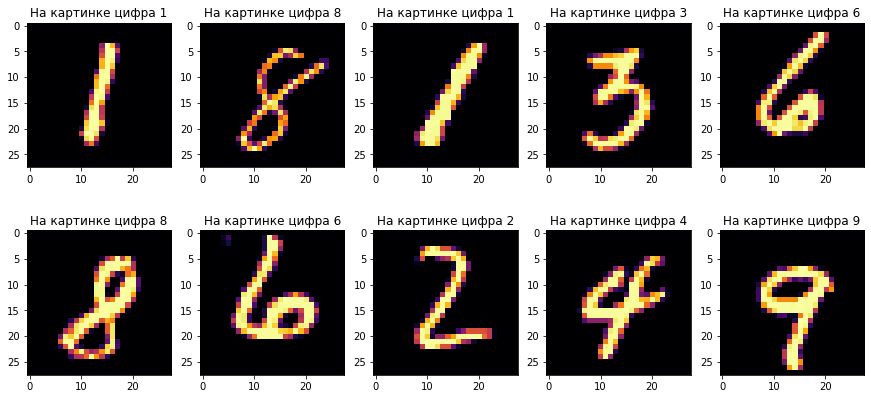

In [5]:
fig, ax = plt.subplots(2, 5, figsize = (15, 7))
for i in range(2):
    for j in range(5):
        a = np.random.randint(0, 55000)
        ax[i, j].imshow(X.reshape(55000, 28, 28)[a], cmap='inferno')
        ax[i, j].set_title(f'На картинке цифра {labels[a]}')

In [6]:
data = my_PCA(2)
X_eig, Y = data.fit_transform(X)

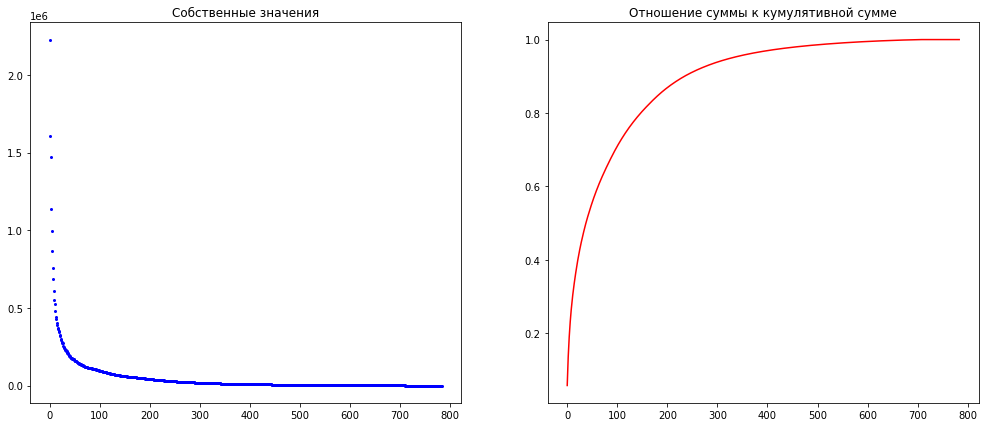

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(17, 7))
ax[0].set_title('Собственные значения')
ax[0].plot(X_eig, linestyle='', marker='o', color='b', ms=2)

S = np.cumsum(X_eig) / np.sum(X_eig)

ax[1].set_title('Отношение суммы к кумулятивной сумме')
ax[1].plot(S, color='red')

Чем больше собственное значение матрицы, тем больше дисперсии покрывает соответствующая главная компонента

In [8]:
S_all = np.sum(X_eig)
S_15 = np.sum(X_eig[:15])
print(f'Первые 15 главных компонент покрывают {int((S_15 / S_all) * 100)}% дисперсии')

Первые 15 главных компонент покрывают 33% дисперсии


In [9]:
Y.shape, Y

((55000, 2),
 array([[ 1.79618427, 13.66970213],
        [-0.53937999, -5.29906678],
        [-3.47238724,  4.8097072 ],
        ...,
        [-3.78513418, -3.34577073],
        [ 1.74304505, -4.97150678],
        [-1.36341209, -6.2870059 ]]))

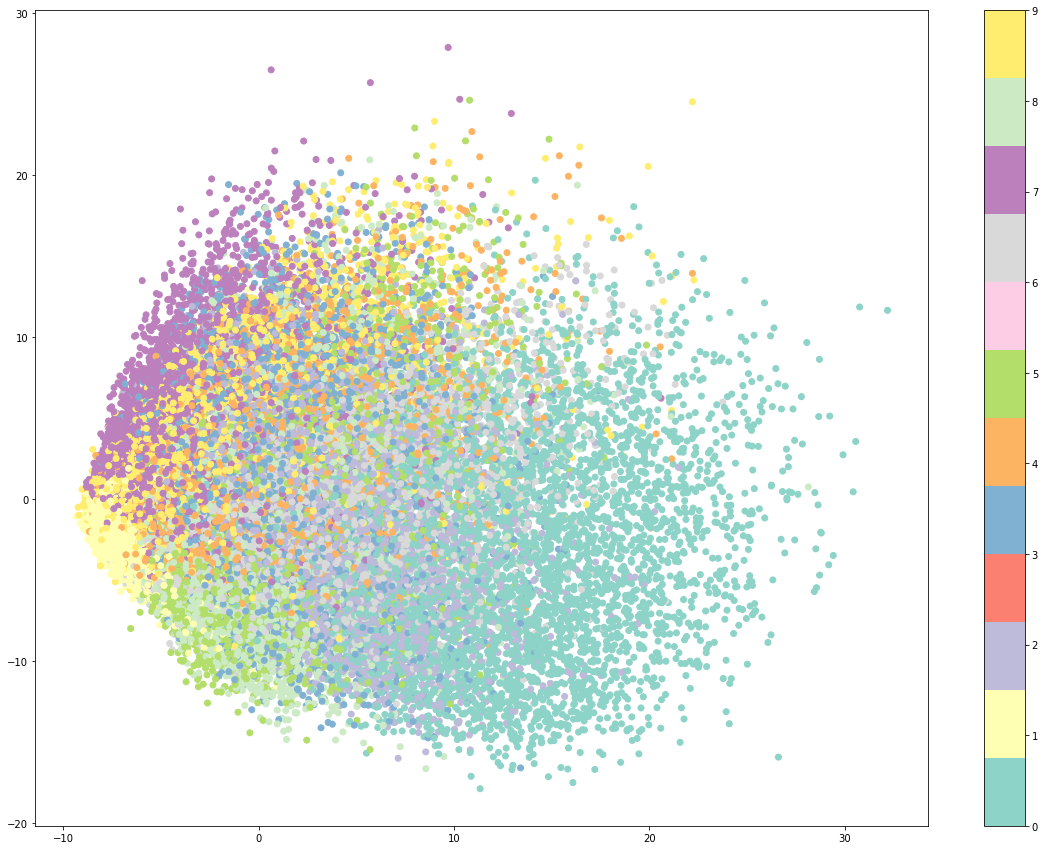

In [10]:
plt.figure(figsize=(20, 15))
plt.scatter(Y[:, 0], Y[:, 1], c=labels, cmap='Set3')
plt.colorbar()

Теоретически, классы можно разделить линейно с некоторой точностью (но идеально разделить их не получится)

In [11]:
X_train, X_test, labels_train, labels_test = train_test_split(X, labels)
X_train.shape, X_test.shape, labels_train.shape, labels_test.shape

((41250, 784), (13750, 784), (41250,), (13750,))

In [12]:
PCA = my_PCA(2)
X_training = PCA.fit_transform(X_train)[1]
X_testing = PCA.transform(X_test)
X_training.shape, X_testing[:, :2].shape

((41250, 2), (13750, 2))

In [17]:
A = np.array([[1, 2], [2, 3], [3, 4]])
A - [0, 2]

array([[1, 0],
       [2, 1],
       [3, 2]])

In [ ]:
acc = []

for n in [2, 5, 10]:
    PCA = my_PCA(n)
    X_training = PCA.fit_transform(X_train)[1]
    X_testing = PCA.transform(X_test)

    knn = my_kNN(5)
    knn.fit(X_training, labels_train)
    answers = knn.predict(X_testing)
    #print(answers)
    acc.append(accuracy_score(labels_test, answers))
    print(acc)
    
plt.plot(acc)

In [ ]:
A = np.array([[1, 0], [0, 3], [-1, 1]])
B = np.array([[0], [0]]).T

for i in A:
    print('aaa')

In [ ]:
pcat = my_PCA(2)
An = pcat.fit_transform(np.array([[1, 2],[2, 3], [1, 3]]))[1]
Bn = pcat.transform(np.array([[1], [2]]))[1]
l = np.array(['a', 'b', 'c'])

In [ ]:
An, Bn

In [ ]:
A.shape, B

In [ ]:
np.linalg.norm(An - Bn, axis=1)

In [ ]:
mini_knn = my_kNN(3)
mini_knn.fit(An, l), mini_knn.predict(Bn)

In [ ]:
A = [1, 2, 3]
B = []
B.append(A.pop(1))
A, B

In [ ]:
G = [1, 2, 2, 3, 1]
stats.mode(G)[0][0]